<a href="https://colab.research.google.com/github/viswambhar-yasa/image_captioning/blob/master/reinforcement_learning_a2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image captioning using reinforcement learning
### Policy to actor method on deep convolution and recurrent networks
#### Project Seminar for artifical intelligence WS2021-22
##### Authors : Viswambhar Yasa, Venkata Mukund 


In [ ]:
!git clone https://github.com/viswambhar-yasa/image_captioning

Cloning into 'image_captioning'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 64 (delta 29), reused 17 (delta 6), pack-reused 0
Unpacking objects: 100% (64/64), done.


In [ ]:
cd /content/image_captioning

/content/image_captioning


In [ ]:
from data_extraction import downloading_extraction

In [ ]:
images_link = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
downloading_extraction(images_link)
text_link = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
downloading_extraction(text_link)

In [ ]:
from model_networks import Caption_model_gen
from data_processing import data_processing

In [ ]:
import tensorflow as tf

In [ ]:
captions_path=r"/content/image_captioning/Flickr8k.token.txt"

In [ ]:
text = open(captions_path, 'r', encoding='utf-8').read()
description_map=dict()
for lines in text.split('\n'):
  line_split = lines.split('\t')
  if line_split == ['']:
      continue
  image_id = line_split[0][:-2]
  image_des = line_split[1]
  #if image_id in img_dic:
  if image_id not in description_map:
    description_map[image_id] = list()
  description_map[image_id].append(image_des)
caption_list = []
for img_id, des_list in description_map.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        caption = ''.join(caption)
        caption = caption.split(' ')
        caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
        caption = ' '.join(caption)
        des_list[i] = 'startseq ' + caption + ' endseq'
        caption_list.append('startseq ' + caption + ' endseq')
max_length = max(len(des.split()) for des in caption_list)
print('max_length of captions', max_length)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8360,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

max_length of captions 33


### loading coco data 

In [ ]:
# Download caption annotation files
# obtained from tensorflow website
import os
annotation_folder = r'/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 400s 0us/step


In [ ]:
import json,collections,random
from PIL import Image

##### extrating annotations of the image

In [ ]:
annotation_file=r'/content/image_captioning/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

['<start> Guy on tennis court gets ready to serve the ball to the other side <end>', '<start> a tennis player on a court holding a racket <end>', '<start> A person on a court with a tennis racket. <end>', '<start> A man with a tennis wrack on a tennis court <end>', '<start> A middle aged man playing tennis without an opponent. <end>']


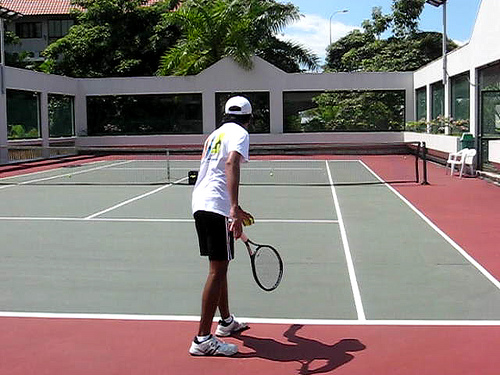

In [ ]:
i=5
print(train_captions[i:i+5])
Image.open(img_name_vector[i])

In [ ]:
from model_losses import loss,Rewards,cos
from data_processing import data_processing
from data_generator import captions_generation_rl,load_preprocess_img

In [ ]:
import os
files=os.listdir(path = '/content/image_captioning/Flicker8k_Dataset')

In [ ]:
description_map1=dict()
for key,value in description_map.items():
  if key in files:
    description_map1[key]=value

##### Performing tokenization : converting words to tokens





In [ ]:
token_cap_dic = dict()
print('Vocab size',len(tokenizer.word_counts))
for img_id, des_list in description_map1.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        cap_token = tokenizer.texts_to_sequences([str(caption)])
        if img_id not in token_cap_dic:
            token_cap_dic[img_id] = list()
        token_cap_dic[img_id].append(cap_token)

Vocab size 8359


##### Creating training, validation and test datasets

In [ ]:
import pickle

print('TensorFlow Version', tf.__version__)
vocab_size = 8400
max_length = 15

captions_text_path = r'/content/image_captioning/Flickr8k.token.txt'
captions_extraction = data_processing(captions_text_path)
trn_images_id_text = r'/content/image_captioning/Flickr_8k.trainImages.txt'
train_cleaned_seq, train_cleaned_dic = captions_extraction.cleaning_sequencing_captions(trn_images_id_text)
val_images_id_text = r'/content/image_captioning/Flickr_8k.devImages.txt'
val_cleaned_seq, val_cleaned_dic = captions_extraction.cleaning_sequencing_captions(val_images_id_text)
test_images_id_text = r'/content/image_captioning/Flickr_8k.testImages.txt'
test_cleaned_seq, test_cleaned_dic = captions_extraction.cleaning_sequencing_captions(test_images_id_text)
captions_extraction.tokenization(train_cleaned_seq, vocab_size)
print("No of captions: Training-" + str(len(train_cleaned_seq) / 5) + " Validation-" + str(
    len(val_cleaned_seq) / 5) + " test-" + str(len(test_cleaned_seq) / 5))

train_cap_tok = captions_extraction.sentence_tokenizing(train_cleaned_dic)
val_cap_tok = captions_extraction.sentence_tokenizing(val_cleaned_dic)
test_cap_tok = captions_extraction.sentence_tokenizing(test_cleaned_dic)

image_pth_rt = r"/content/image_captioning/Flicker8k_Dataset/" #+ r"\\"
trn_dataset = captions_generation_rl(train_cap_tok, vocab_size, image_pth_rt, 25,5,1)
val_dataset = captions_generation_rl(val_cap_tok, vocab_size, image_pth_rt, 25,32,1)

inputs = next(iter(trn_dataset))
print(inputs[0][0].shape, inputs[1].shape)

TensorFlow Version 2.8.0
max_length of captions 33
max_length of captions 31
max_length of captions 30
No of captions: Training-6000.0 Validation-1000.0 test-1000.0
Vocab size 8400
Vocab size 8400
Vocab size 8400
(60, 256, 256, 3) (60, 8400)


In [ ]:
def caption_greedy(policy_net,image,tokenizer,word_index,max_length=25):
  caption='startseq'
  for i in range(max_length):
    input_seq=caption.split(' ')
    tokenization=tokenizer.texts_to_sequences(input_seq)
    padding=tf.keras.preprocessing.sequence.pad_sequences([tokenization],maxlen=max_length) 
    predicted_word_index=np.argmax(policy_net.predict([tf.expand_dims(image,axis=0),padding]))
    predicted_word=word_index[predicted_word_index]
    caption+=' '+predicted_word
    if predicted_word =='endseq':
      break
  return caption

#### Building policy net and loading saved weights

In [ ]:
actor_model = Caption_model_gen(NET='policy', vocab_size=8400, Embed_Size=512, max_length=25,display=True)

Building CNN model
83697664/83683744 [==============================] - 0s 0us/step
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image and text {add shape}: (None, 512)
output {shape} (None, 8400)
Policy Net built successfully 



In [ ]:
actor_model.load_weights('/content/drive/MyDrive/Kaggle/policy_net_weights_whole.h5')

#### Building reward net and loading saved weights

In [ ]:
reward_model = Caption_model_gen(NET='reward', vocab_size=8400, Embed_Size=512, max_length=25,display=True)

Building CNN model
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image feature vector shape: (None, 512)
Text sequence vector shape: (None, 512)
Reward Net built successfully 



In [ ]:
reward_model.load_weights('/content/drive/MyDrive/Kaggle/final_reward_net_weights_all.h5')

#### Building value net and loading saved weights

In [ ]:
value_model = Caption_model_gen(NET='value', vocab_size=8400, Embed_Size=512, max_length=25,display=True)

Building CNN model
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image and text {concat shape}: (None, 1024)
output {shape} (None, 1)
Value Net built successfully 



In [ ]:
value_model.load_weights('/content/drive/MyDrive/Kaggle/value_net_weights_all.h5')

In [ ]:
word_index=tokenizer.word_index
word_index={value:key for key, value in word_index.items()}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#### Building captions using trained model

In [ ]:
def caption_greedy(policy_net,image,tokenizer,word_index,max_length=25):
  caption='startseq'
  for i in range(max_length):
    input_seq=caption.split(' ')
    tokenization=tokenizer.texts_to_sequences(input_seq)
    padding=tf.keras.preprocessing.sequence.pad_sequences([tokenization],maxlen=max_length) 
    predicted_word_index=np.argmax(policy_net.predict([tf.expand_dims(image,axis=0),padding]))
    predicted_word=word_index[predicted_word_index]
    caption+=' '+predicted_word
    if predicted_word =='endseq':
      break
  return caption

In [ ]:
def beam_search(policy_net,image,word_index,width=5,max_length=25):
  start_word=[[[2],0]]
  for i in range(max_length):
    temp=[]
    for s in start_word:
      padding=tf.keras.preprocessing.sequence.pad_sequences([s[0]],maxlen=max_length,padding='post')
      pre=policy_net.predict([tf.expand_dims(image,axis=0),padding])
      predicted_word_index=np.argsort(pre)[0]
      words_predicted=predicted_word_index[-width:]
      for words in words_predicted:
        next_cap, prob = s[0][:], s[1]
        
        next_cap.append(words)
        prob += pre[0][words]
        temp.append([next_cap, prob])

    start_word = temp
        # Sorting according to the probabilities
    start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
    start_word = start_word[-width:]

  start_word = start_word[-1][0]
  intermediate_caption = [word_index[i] for i in start_word]
  final_caption = []
  for i in intermediate_caption:
    if i != 'endseq':
      final_caption.append(i)
    else:
      break
    
  final_caption = ' '.join(final_caption[1:])
  return final_caption

In [ ]:
def beam_search_val(policy_net,value_net,image,word_index,width=15,max_length=25):
  start_word=[[[2],0]]
  for i in range(max_length):
    temp=[]
    for s in start_word:
      padding=tf.keras.preprocessing.sequence.pad_sequences([s[0]],maxlen=max_length,padding='post')
      pre=policy_net.predict([tf.expand_dims(image,axis=0),padding])
      predicted_word_index=np.argsort(pre)[0]
      words_predicted=predicted_word_index[-width:]
      for words in words_predicted:
        next_cap, prob = s[0][:], s[1]

        next_cap.append(words)
        
        val_pad=tf.keras.preprocessing.sequence.pad_sequences([next_cap],maxlen=max_length,padding='post')
        val_prob=value_net([tf.expand_dims(image,axis=0),padding])[0]
        prob += pre[0][words]+val_prob[0]
        temp.append([next_cap, prob])

    start_word = temp
        # Sorting according to the probabilities
    start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
    start_word = start_word[-width:]

  start_word = start_word[-1][0]
  intermediate_caption = [word_index[i] for i in start_word]
  final_caption = []
  for i in intermediate_caption:
    if i != 'endseq':
      final_caption.append(i)
    else:
      break
    
  final_caption = ' '.join(final_caption[1:])
  return final_caption

In [ ]:
def load_image_coco(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(256, 256)(img)
    img/= 255.0
    return img, image_path

In [ ]:
i=20
img,img_pah=load_image_coco(img_name_vector[i])
print(train_captions[i*5:i*5+5])

['<start> A man sitting next to a woman on a pile of snow. <end>', '<start> A man and woman sitting in the snow with backpacks and skis. <end>', '<start> Happy couple relaxing and enjoying their ski vacation. <end>', '<start> A woman and a man sit on the snow resting after skiing.  <end>', '<start> Two people sitting on snow, in front of a large pine tree, with the skis stuck in the snow to their sides. <end>']


In [ ]:
test_img=list(train_cap_tok.keys())[12]
test_photo = load_preprocess_img(image_pth_rt + test_img)
cap=caption_greedy(actor_model,img,tokenizer,word_index)
plt.imshow(img)
plt.title(cap)
plt.savefig('myfig.png',dpi=600)
print(cap)
print(train_cleaned_dic[test_img])
tokenization=tokenizer.texts_to_sequences([cap])
seq_cap=tf.keras.preprocessing.sequence.pad_sequences(tokenization, maxlen=25,
                                                                            padding='post')
input_ds=[tf.expand_dims(test_photo,axis=0),seq_cap]
value=value_model(input_ds)
reward=Rewards(reward_model,input_ds)
print('value :',value[0],' reward :',reward)

NameError: ignored

and dog through kitchen


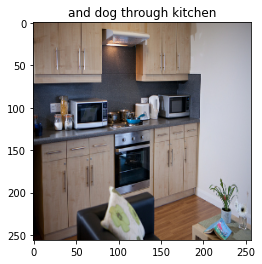

In [ ]:
#test_img=list(train_cap_tok.keys())[12]
#test_photo = load_preprocess_img(image_pth_rt + test_img)
cap=beam_search(actor_model,img,word_index)
plt.imshow(img)
plt.title(cap)
print(cap)

dog through kitchen in


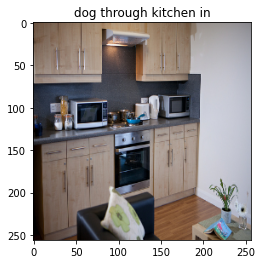

In [ ]:
test_img=list(train_cap_tok.keys())[12]
test_photo = load_preprocess_img(image_pth_rt + test_img)
cap=beam_search_val(actor_model,value_model,img,word_index)
plt.imshow(img)
plt.title(cap)
print(cap)

<start> A clock in front of an abstract design. <end>


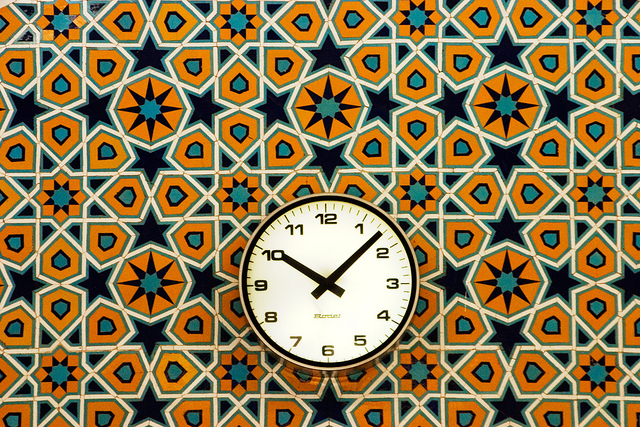

In [ ]:
i=500
print(train_captions[i])
Image.open(img_name_vector[i])

In [ ]:
img,img_pah=load_image_coco(img_name_vector[i])

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8400,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

startseq children in and stand near endseq
value : tf.Tensor([0.20511074], shape=(1,), dtype=float32)  reward : tf.Tensor([0.12620705], shape=(1,), dtype=float32)


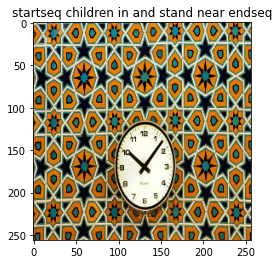

In [ ]:
trn_dataset_whole = captions_generation(token_cap_dic, vocab_size, image_pth_rt, max_length=25,num_photos_per_batch=32,num_captions=1)

In [ ]:
inputs = next(iter(trn_dataset))

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001)
history={}
history['loss']=list()
history['val_loss']=list()
metrics_names = ['loss'] 
epochs = 1
num_epoch=200
for i in range(epochs):
    n=0
    epoch=0
    for step, x_batch_train in enumerate(trn_dataset_whole):
        if epoch==num_epoch:
          break
        progbar = tf.keras.utils.Progbar(10,stateful_metrics=['loss'])
        with tf.GradientTape() as tape:
            [visual,sematic] = reward_model(x_batch_train, training=True)  # Logits for this minibatch
            loss_value = loss(visual, sematic)
            
        grads = tape.gradient(loss_value, reward_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, reward_model.trainable_weights))
        progbar.update(n, values = [("loss", loss_value)])
        # Log every 200 batches.
        n+=1
        if loss_value < 0.05:
          break
        if step % 10 == 0:
            epoch+=1
            val_ds=next(iter(val_dataset))
            [val_visual,val_sematic] = reward_model(val_ds)
            val_loss_value=loss(val_visual, val_sematic)
            progbar.add(1,values = [("val_loss", val_loss_value)])
            n=0
            print("\nepoch %d" % (epoch,))
            history['loss'].append(loss_value)
            history['val_loss'].append(val_loss_value)


In [ ]:
f = open("/content/history_value_model_SGD_incp_lstm.pkl", "wb")
pickle.dump(history, f)
f.close() 

In [ ]:
#value_model.save_weights('/content/drive/MyDrive/Kaggle/value_net_weights_all.h5')